



Here, we aggregate (by concatenation) the hitting time distributions, so that we can use themfor doing logrank comparisons.



In [2]:
import netsim_summariser as summ

In [3]:
import itertools
import numpy as np
from scipy import stats, special
import polars as pl
from matplotlib import pyplot as plt, cycler
import seaborn as sns
from pathlib import Path

sns.set()
sns.set_palette('colorblind')

In [4]:
metrics_archives = {
    'temporal': './zero_sims/temporal/metrics_30s.parquet',
    'static': './zero_sims/static/metrics_30s_fa.parquet',
    'snapshot': './zero_sims/snapshot/metrics_30s_fa.parquet',
    'snapshot_2': './zero_sims/snapshot/metrics_30s_fa_r2.parquet',
    'naive_static': './zero_sims/naive_static/metrics_30s.parquet',
}

processed_results = {}

for label, archive in metrics_archives.items():
        processed_results[label] = pl.read_parquet(archive)


In [13]:
hitting_time_columns = pl.selectors.starts_with('hitting_time_')

agg_metrics = dict()
hitting_time_dists = dict()
for model, metrics in processed_results.items():
    agg_met = (metrics
                   .unpivot(
                     on=hitting_time_columns, 
                     index='seed', 
                     variable_name='target', 
                     value_name='hitting_time'
                   )
                   .with_columns(target_seed=(
                       pl.col('target')
                       .str.strip_prefix('hitting_time_')
                       .str.to_integer()
                   ))
                   .drop('target')
    )
    agg_metrics[model] = agg_met
    hitting_time_dists[model] = np.sort(agg_met.select('hitting_time').to_series().to_numpy())

In [24]:
static_order = agg_metrics['static'].sort('hitting_time', nulls_last=True).with_row_index()

In [26]:
static_330 = static_order.filter(pl.col('target_seed').eq(330)).select(pl.col('index').cast(pl.Float64) / static_order.shape[0], pl.col('hitting_time'))


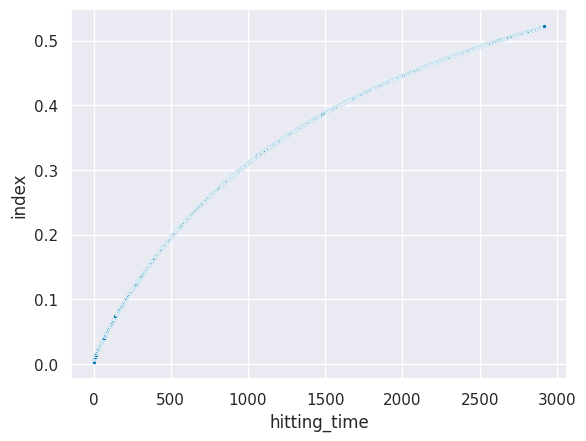

In [29]:
ax_330 = sns.scatterplot(static_330, y='index', x='hitting_time', marker='.')

In [30]:
# analytical_expected_hitting_naive = np.loadtxt("concordant_networks/analyses/naive_static_hitting_times_multichain_30.txt")
analytical_expected_hitting_naive = pl.read_csv("hitting_time_analysis/numer_hitting_time_30indv_chains.csv")
# ana_E_hitT_naive = np.sort(analytical_expected_hitting_naive.flatten())
ana_E_hitT_naive = np.sort(analytical_expected_hitting_naive.select('hitting_time').to_series().to_numpy().flatten())

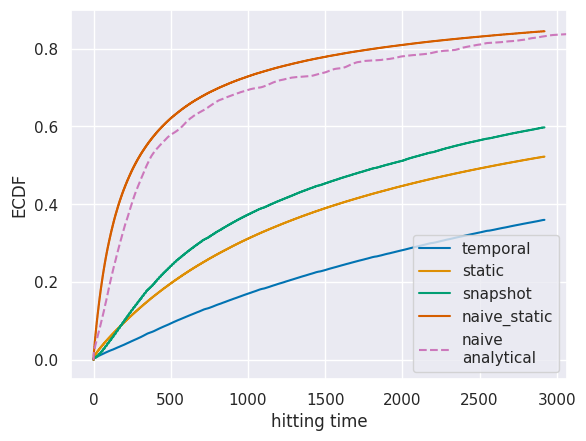

In [34]:
plt.figure()
for model, dist in hitting_time_dists.items():
    if model == 'snapshot_2': continue
    plt.plot(dist, np.linspace(0, 1, len(dist), endpoint=False), label=model)

xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()

plt.plot(ana_E_hitT_naive, np.linspace(0, 1, len(ana_E_hitT_naive)), 
         label='naive\nanalytical', linestyle='dashed')

plt.xlim(xlim)
plt.ylim(None, 0.9)

# plt.ylim(1e-3, None)
plt.xlabel('hitting time')
plt.ylabel('ECDF')

plt.legend(loc='lower right')
plt.savefig('hitting_time_analysis/comparative_at_a_glance.png', dpi=360)

In [48]:
%matplotlib inline

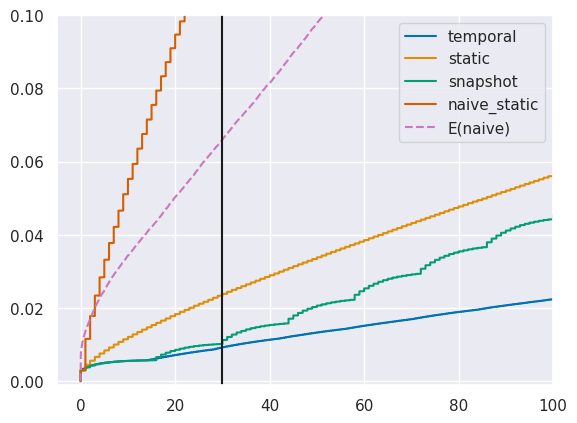

In [52]:
plt.figure()

for model, dist in hitting_time_dists.items():
    if model == "snapshot_2": continue
    plt.plot(dist, np.linspace(0, 1, len(dist), endpoint=False), label=model)

plt.plot(ana_E_hitT_naive, np.linspace(0, 1, len(ana_E_hitT_naive)), label='E(naive)', linestyle='dashed')


plt.xlim(-5, 100)
plt.ylim(-1e-3, 0.1)

# plt.yscale('log')

plt.axvline(30, color='k')

plt.legend(loc='upper right')

In [40]:
def without_nan(dist):
    return dist[np.isfinite(dist)]

def compose_truncated(dist, maxv):
    return np.array([
        *without_nan(dist),
        *(np.ones_like(dist[np.isnan(dist)]) * maxv)
    ])

def compose_censored(dist, maxv):
    return stats.CensoredData(
        uncensored=dist[np.isfinite(dist)],
        right=np.ones_like(dist[np.isnan(dist)]) * maxv
    )

def logrank(a, b, maxv=8*365+1, **kwargs):
    return stats.logrank(
        compose_censored(a, maxv),
        compose_censored(b, maxv),
        **kwargs
    )

In [9]:
logrank(hitting_time_dists['naive_static'], hitting_time_dists['static'])

LogRankResult(statistic=-67.58003924491268, pvalue=0.0)

In [23]:
logrank(hitting_time_dists['naive_static'], hitting_time_dists['snapshot'])

LogRankResult(statistic=-1597.642807424247, pvalue=0.0)

In [24]:
logrank(hitting_time_dists['naive_static'], hitting_time_dists['snapshot_2'])

/home/davidwu/.virtualenvs/monv/lib/python3.12/site-packages/scipy/stats/_survival.py:680: RuntimeWarning: invalid value encountered in sqrt
  statistic = (n_died_x - sum_exp_deaths_x)/np.sqrt(sum_var)


LogRankResult(statistic=nan, pvalue=nan)

In [25]:
logrank(hitting_time_dists['snapshot'], hitting_time_dists['snapshot_2'])

LogRankResult(statistic=-114.37204637216132, pvalue=0.0)

In [11]:
logrank(hitting_time_dists['naive_static'], hitting_time_dists['temporal'])

LogRankResult(statistic=1072.564183402295, pvalue=0.0)

In [42]:
sn_diff = stats.ks_2samp(
    compose_truncated(hitting_time_dists['snapshot'], 8*365+2), 
    compose_truncated(hitting_time_dists['snapshot_2'], 8*365+2)
)

In [43]:
sn_diff.statistic

0.003898673015650722

In [44]:
sn_diff.statistic_location

2102.0

In [ ]:
hitting_time_dists['static']

In [6]:
processed_results

{'temporal': shape: (6_760, 346)
 ┌──────┬─────────┬─────────┬────────────────┬───┬──────────┬───────────────┬────────┬─────────────┐
 │ seed ┆ simdate ┆ simtime ┆ hitting_time_0 ┆ … ┆ ssi_std  ┆ emptying_time ┆ extent ┆ extent_time │
 │ ---  ┆ ---     ┆ ---     ┆ ---            ┆   ┆ ---      ┆ ---           ┆ ---    ┆ ---         │
 │ i64  ┆ str     ┆ str     ┆ f64            ┆   ┆ f64      ┆ f64           ┆ u32    ┆ i32         │
 ╞══════╪═════════╪═════════╪════════════════╪═══╪══════════╪═══════════════╪════════╪═════════════╡
 │ 0    ┆ 241009  ┆ 182513  ┆ 0.0            ┆ … ┆ 0.0524   ┆ 105.0         ┆ 3      ┆ 30          │
 │ 0    ┆ 241009  ┆ 183324  ┆ 0.0            ┆ … ┆ 0.0482   ┆ 139.0         ┆ 2      ┆ 30          │
 │ 0    ┆ 241009  ┆ 194603  ┆ 0.0            ┆ … ┆ 0.048708 ┆ 87.0          ┆ 2      ┆ 30          │
 │ 0    ┆ 241009  ┆ 195403  ┆ 0.0            ┆ … ┆ 0.049855 ┆ 82.0          ┆ 4      ┆ 30          │
 │ 0    ┆ 241009  ┆ 200204  ┆ 0.0            ┆ … ┆ 0.05161

In [7]:
combined_all_df = pl.concat(
    [df.select('seed', 'extent').with_columns(pl.lit(label).alias('simulation'), pl.col('extent').cast(pl.Int64))
     for label, df in processed_results.items()]
)

combined_sort_order = combined_all_df.group_by('seed').median().select('seed', 'extent').sort('extent', descending=True).select('seed').with_row_index('sorted_seed')

combined_all_df = combined_all_df.join(combined_sort_order, on='seed')

In [12]:
def compute_median_extent(df: pl.DataFrame):
    return df.group_by('seed').median().select('seed', 'extent')


In [13]:
combined_median_df = pl.concat(
    [compute_median_extent(df).with_columns(pl.lit(label).alias('simulation'))
     for label, df in processed_results.items()]
)

combined_median_sort = combined_median_df.group_by('seed').median().select('seed', 'extent').sort('extent', descending=True).select('seed').with_row_index('sorted_seed')

combined_median_df = combined_median_df.join(combined_median_sort, on='seed')

In [14]:


paired_median_df = combined_median_df.pivot("simulation", index="sorted_seed", values="extent").fill_null(0.0)

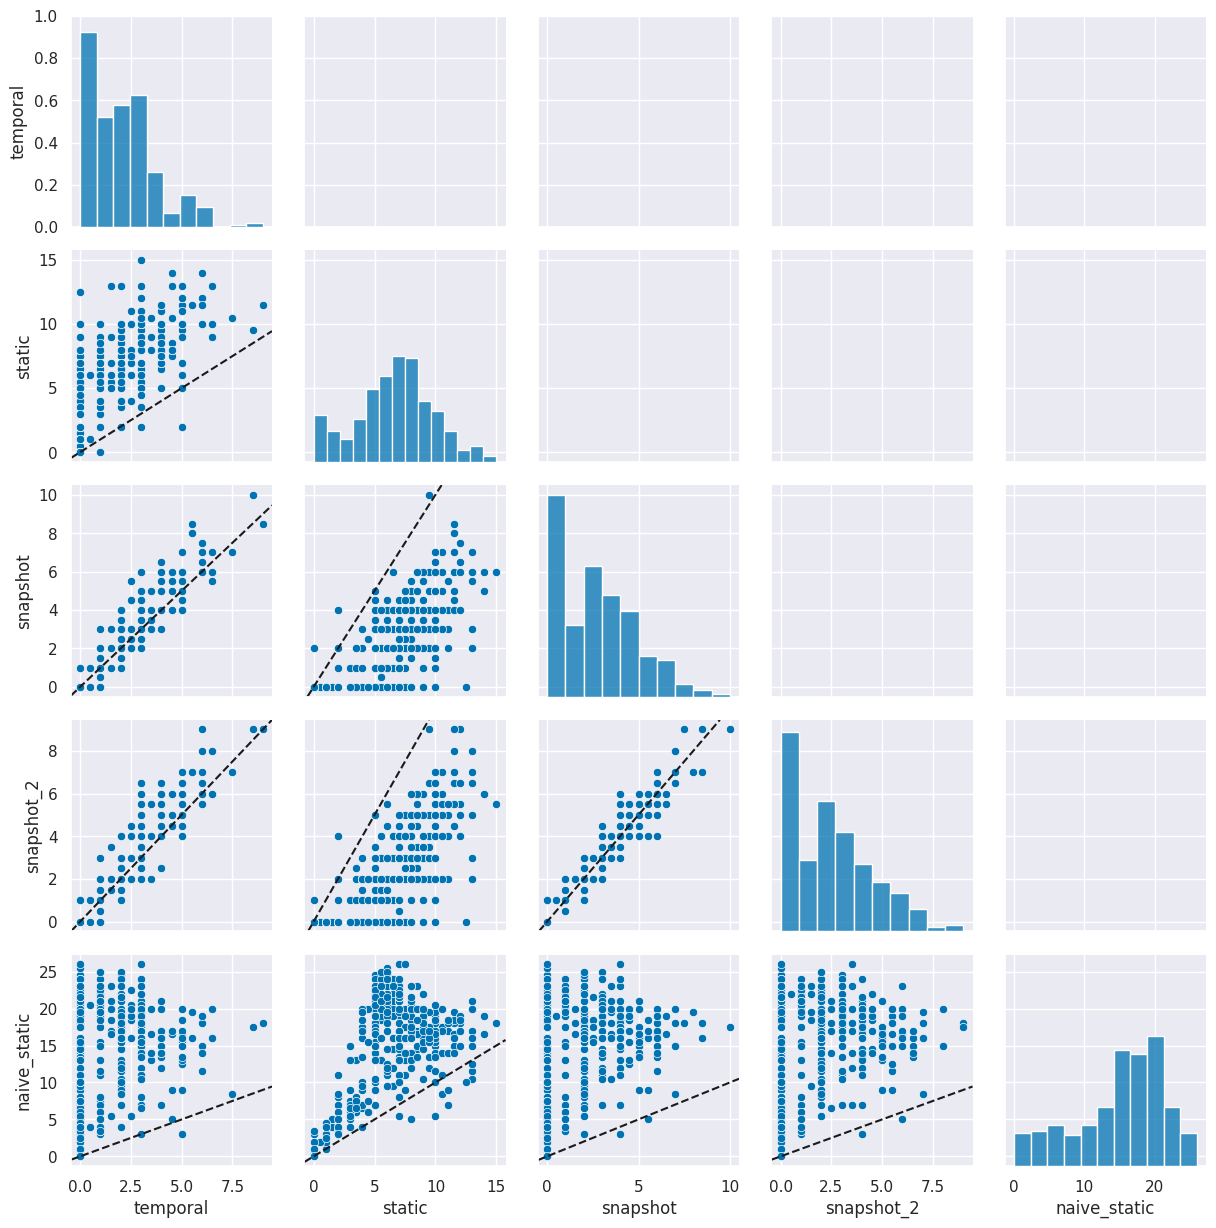

In [15]:
ppl = sns.PairGrid(paired_median_df.to_pandas(), vars=list(processed_results.keys()))
ppl.map_lower(sns.scatterplot)
ppl.map_diag(sns.histplot)
# ppl.map_upper(sns.scatterplot)
ppl.map_lower(lambda *a, **k: plt.axline((0,0), slope=1, linestyle='dashed', color='k'))
